<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [67]:
from google.colab import drive
drive.mount('/content/drive/')

link = '/content/drive/MyDrive/Deep_Learning_School/12_autoencoders/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [121]:
import os
import copy
from pathlib import Path
import torch
import random
import numpy as np
import pandas as pd
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
#!pip install torchinfo
from torchinfo import summary
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import TensorDataset, DataLoader
import torchvision.utils
import matplotlib.pyplot as plt
import skimage.io
from tqdm.notebook import tqdm
from IPython.display import clear_output
from skimage.transform import resize
from scipy.stats import kurtosis, skew
from scipy import stats
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import statistics
import seaborn as sns
from matplotlib.gridspec import GridSpec
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [69]:
SEED = 123
RANDOM_STATE = SEED
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [70]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                  images_name = "lfw-deepfunneled",
                  dx=80, dy=80,
                  dimx=64, dimy=64):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    file_attrs = df[['photo_path', 'person', 'imagenum']]
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs, file_attrs

In [71]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs, file_attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [72]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [73]:
train_data, valid_data, train_attrs, valid_attrs = train_test_split(
    data, attrs, train_size=0.8, shuffle=False, random_state=RANDOM_STATE
)

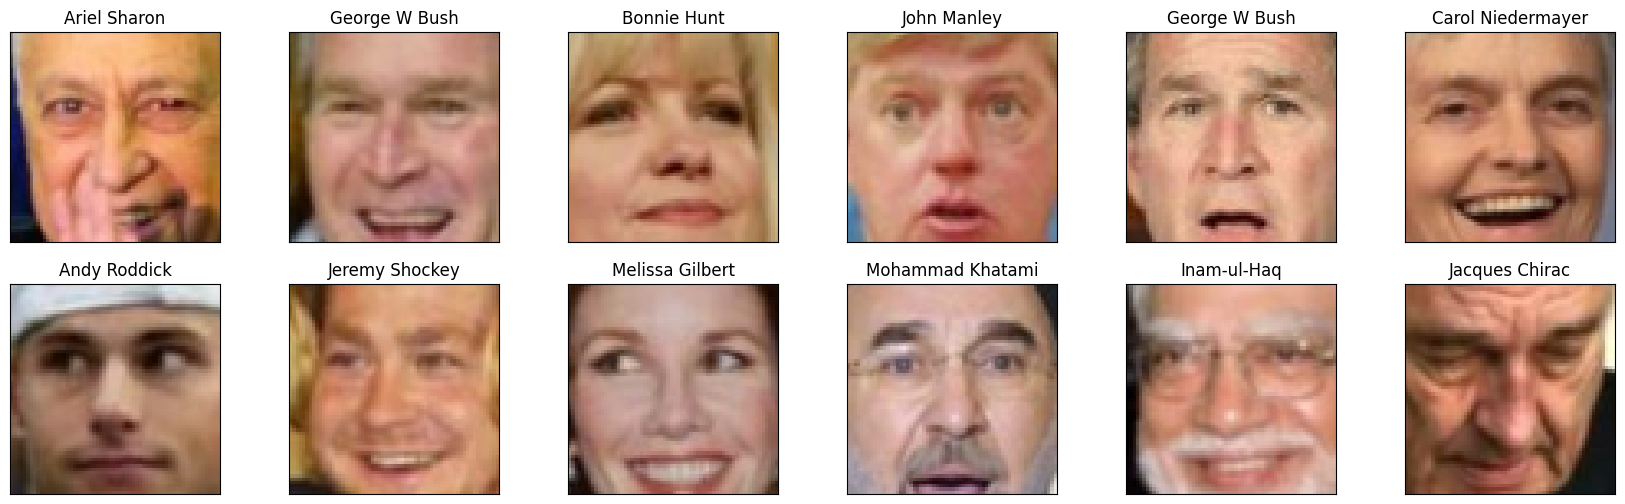

In [74]:
fig, axes = plt.subplots(2, 6, figsize=(21, 6), sharey=True, sharex=True)

for ax in axes.flatten():
    idx = random.randrange(0, train_data.shape[0])
    ax.imshow(train_data[idx])
    plt.xticks([])
    plt.yticks([])
    ax.set_title(file_attrs['person'].iloc[idx])
    plt.grid(True)
plt.show()

In [75]:
batch_size = 32
train_data_size = len(train_data)
valid_data_size = len(valid_data)

train_data = torch.FloatTensor(train_data).permute(0, 3, 1, 2)
valid_data = torch.FloatTensor(valid_data).permute(0, 3, 1, 2)

train_loader = DataLoader(
    train_data, batch_size=batch_size, num_workers=4
)

valid_loader = DataLoader(
    valid_data, batch_size=batch_size, num_workers=4
)

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [76]:
num_epochs = 100
kernel_size = 3
stride = 2
padding = 1
lr = 1e-4
batchNorm_momentum = 0.1
channels = 3 # количество каналов изображения
latent_dim = 512 # размерность латентного вектора
init_channels = 16 # минимальный размер фильтров в Conv слоях энкодера/декодера

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [77]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=channels,
                      out_channels=init_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_channels,
                      out_channels=init_channels * 2,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.BatchNorm2d(init_channels * 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_channels * 2,
                      out_channels=init_channels * 4,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.BatchNorm2d(init_channels * 4),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(init_channels ** 3, latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, init_channels ** 3),
            nn.Unflatten(dim=1, unflattened_size=(init_channels * 4, 8, 8)),
            nn.ConvTranspose2d(in_channels=init_channels * 4,
                               out_channels=init_channels * 2,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding,
                               output_padding=padding),
            nn.BatchNorm2d(init_channels * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=init_channels * 2,
                               out_channels=init_channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding,
                               output_padding=padding),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=init_channels,
                               out_channels=channels,
                               kernel_size=kernel_size,
                               stride=stride,
                               padding=padding,
                               output_padding=padding),
            nn.BatchNorm2d(channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        return reconstruction, latent_code

    def sample(self, x):
        reconstruction = self.decoder(x)
        return reconstruction

summary(Autoencoder().to(device), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5           [-1, 32, 16, 16]              64
              ReLU-6           [-1, 32, 16, 16]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
       BatchNorm2d-8             [-1, 64, 8, 8]             128
              ReLU-9             [-1, 64, 8, 8]               0
          Flatten-10                 [-1, 4096]               0
           Linear-11                  [-1, 512]       2,097,664
           Linear-12                 [-1, 4096]       2,101,248
        Unflatten-13             [-1, 64, 8, 8]               0
  ConvTranspose2d-14           [-1, 32,

In [78]:
criterion = nn.MSELoss()
autoencoder = Autoencoder()
autoencoder = autoencoder.to(device)
optimizer = optim.Adam(autoencoder.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [79]:
def train(model, optimizer, criterion,
          train_loader, valid_loader,
          scheduler=None, is_vae=False,
          is_conditional=False, learning_rate=lr):
    best_model_weights = model.state_dict()
    best_loss_valid = np.inf

    outputs = []
    train_losses = []
    valid_losses = []
    person = file_attrs['person'].tail(5).values.tolist()

    for epoch in tqdm(range(num_epochs)):
        model.train()
        train_losses_per_epoch = []

        for inputs in train_loader:
            optimizer.zero_grad()
            if is_vae and not is_conditional:
                inputs = inputs[0].to(device)
                output, mu, logsigma = model(inputs)
                loss = criterion(inputs, mu, logsigma, output)
            elif is_conditional and is_vae:
                images, labels = inputs
                images = images.to(device)
                labels = labels.to(device)
                output, mu, logsigma = model(images, labels)
                loss = criterion(images, mu, logsigma, output)
            else:
                inputs = inputs.to(device)
                output, _ = model(inputs)
                loss = criterion(output, inputs)

            loss.backward()
            optimizer.step()

            train_losses_per_epoch.append(loss.item())
        train_losses.append(np.mean(train_losses_per_epoch))

        if scheduler is not None:
            scheduler.step()

        model.eval()
        valid_losses_per_epoch = []

        with torch.no_grad():
            for inputs in valid_loader:
                if is_vae and not is_conditional:
                    inputs = inputs[0].to(device)
                    output, mu, logsigma = model(inputs)
                    loss = criterion(inputs, mu, logsigma, output)
                elif is_conditional and is_vae:
                    images, labels = inputs
                    images = images.to(device)
                    labels = labels.to(device)
                    reconstructed, mu, logsigma = model(images, labels)
                    loss = criterion(images, mu, logsigma, reconstructed)
                    inputs = images
                else:
                    inputs = inputs.to(device)
                    output, _ = model(inputs)
                    loss = criterion(output, inputs)

                valid_losses_per_epoch.append(loss.item())
        valid_losses.append(np.mean(valid_losses_per_epoch))

        outputs.append((epoch, inputs, output),)
        if valid_losses[epoch] < best_loss_valid:
            best_loss_valid = valid_losses[epoch]
            best_model_weights = copy.deepcopy(model.state_dict())

        clear_output(wait=True)
        fig = plt.figure(figsize=(12,6))
        fig.suptitle('%d / %d - train_loss: %f , valid_loss: %f' % (
            epoch + 1, num_epochs,
            np.mean(train_losses_per_epoch),
            np.mean(valid_losses_per_epoch)),
                     y=1, fontsize = 16
        )

        gs1 = GridSpec(2, 5, left=0.0001, right=1.0, wspace=0.05)
        ax1 = fig.add_subplot(gs1[:-1, :1])
        ax2 = fig.add_subplot(gs1[:-1, 1])
        ax3 = fig.add_subplot(gs1[:-1, 2])
        ax4 = fig.add_subplot(gs1[:-1, 3])
        ax5 = fig.add_subplot(gs1[:-1, -1])

        ax6 = fig.add_subplot(gs1[-1, :1])
        ax7 = fig.add_subplot(gs1[-1, 1])
        ax8 = fig.add_subplot(gs1[-1, 2])
        ax9 = fig.add_subplot(gs1[-1, 3])
        ax10 = fig.add_subplot(gs1[-1, 4])

        gs2 = GridSpec(2, 2, left=1.1, right=2.0, hspace=0.05)
        ax11 = fig.add_subplot(gs2[:, :-1])

        axis =[ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11]
        for k in range(11):
          if k < 5:
              axis[k].imshow(inputs[k].detach().cpu().permute(1,2,0))
              axis[k].set_title('Real / ')
              axis[k].grid(False)
              axis[k].axis('off')
          elif 4 < k < 10:
              axis[k].imshow(output[k-5].detach().cpu().permute(1,2,0))
              axis[k].set_title('Reconstruction')
              axis[k].grid(False)
              axis[k].axis('off')
          else:
              axis[k].plot(np.arange(len(train_losses)), train_losses, label='Train', color = "green")
              axis[k].plot(np.arange(len(valid_losses)), valid_losses, label='Validation', color = "orange")
              axis[k].set_xlabel('Epoch')
              axis[k].set_title('MSE loss', fontsize = 16)
              axis[k].legend()
              axis[k].legend(fontsize = 14)
              axis[k].grid(linestyle = "--")
              axis[k].tick_params(labelsize = 14)
              axis[k].set_xlabel("Epoch", fontsize = 14)
              axis[k].set_ylabel("Loss", fontsize = 14)
              axis[k].set_xlim(left=0, right=len(train_losses))
              axis[k].set_ylim(bottom=0, top=max(max(train_losses), max(valid_losses))*1.2)
        plt.show()

    model.load_state_dict(best_model_weights)

    inputs.to("cpu")
    output.to("cpu")
    #model.to("cpu")

    del inputs
    del output
    #del model
    torch.cuda.empty_cache()

In [80]:
trained = True
if not trained:
    train(autoencoder, optimizer, criterion,
          train_loader, valid_loader, scheduler)
else:
    autoencoder.load_state_dict(torch.load(link + 'ae_weights.pth'))

In [81]:
torch.save(autoencoder.state_dict(), link + 'ae_weights.pth')

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [82]:
def reconstruct(model, loader, is_vae=False, is_conditional=False):
    model.eval()
    if is_vae and not is_conditional:
        images = next(iter(loader))
        images = images[0].to(device)
        with torch.no_grad():
            output, _, _ = model(images)
    elif is_vae and is_conditional:
        batch = next(iter(loader))
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        with torch.no_grad():
            output, _, _ = model(images, labels)
    else:
        images = next(iter(loader))
        images = images.to(device)
        with torch.no_grad():
            output, _ = model(images.to(device))

    fig, axes = plt.subplots(2, 6, figsize=(22, 6), sharey=True, sharex=True)

    for i in range(2):
        for j in range(6):
            ax = axes[i, j]
            if i == 0:
                ax.imshow(images[j].cpu().permute(1, 2, 0))
                ax.set_title('Real')
            else:
                ax.imshow(output[j].cpu().permute(1, 2, 0))
                ax.set_title('Reconstructed')
            ax.axis('off')
    plt.show()

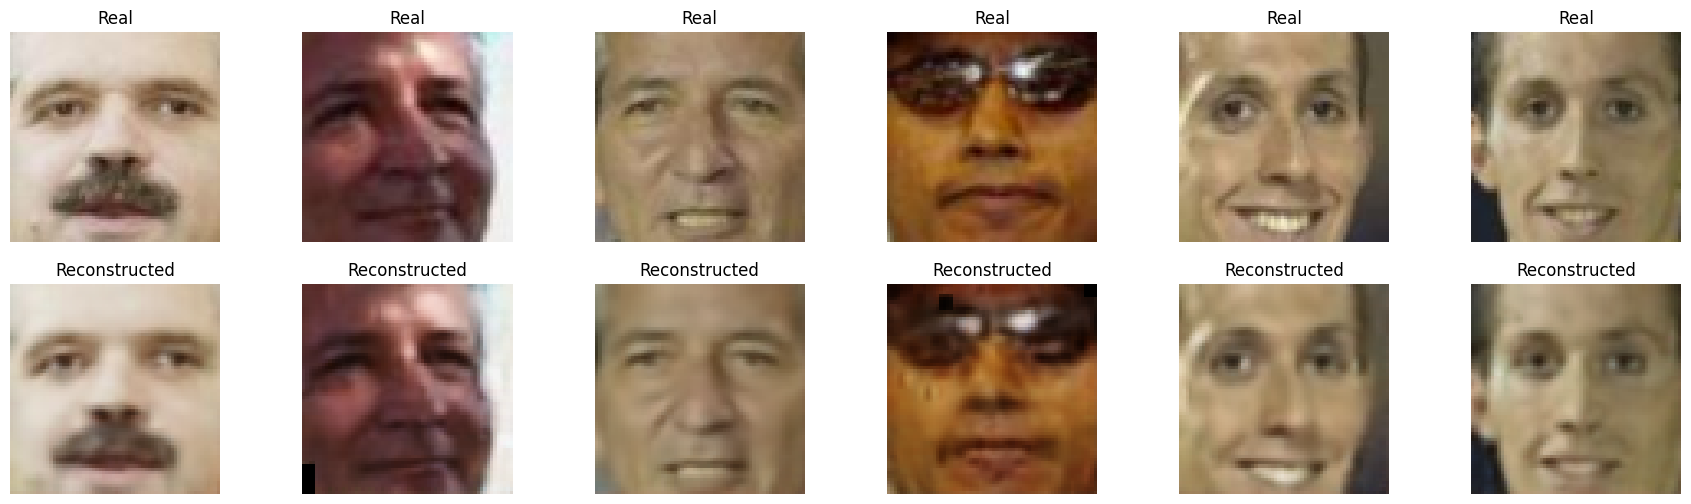

In [83]:
reconstruct(autoencoder, valid_loader)

Not bad, right?

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

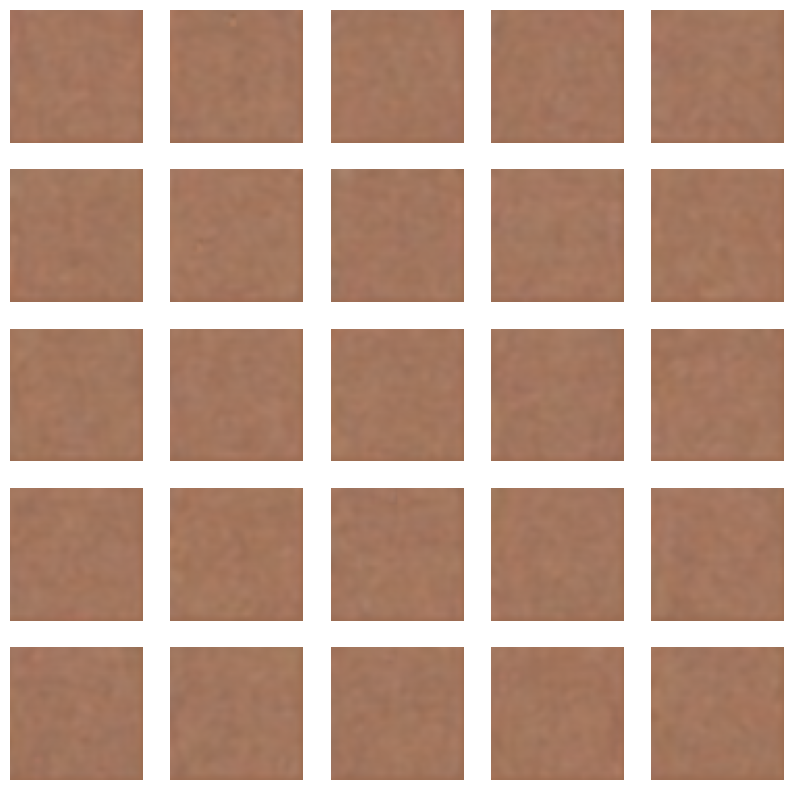

In [84]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, latent_dim)
output = autoencoder.sample(torch.FloatTensor(z).to(device))

plt.figure(figsize=(10, 10))
for i in range(output.shape[0]):
    plt.subplot(5, 5, i + 1)
    generated = output[i].permute(1, 2, 0).cpu().detach().numpy()
    plt.imshow(generated)
    plt.axis('off')
plt.show()

Как-то не очень

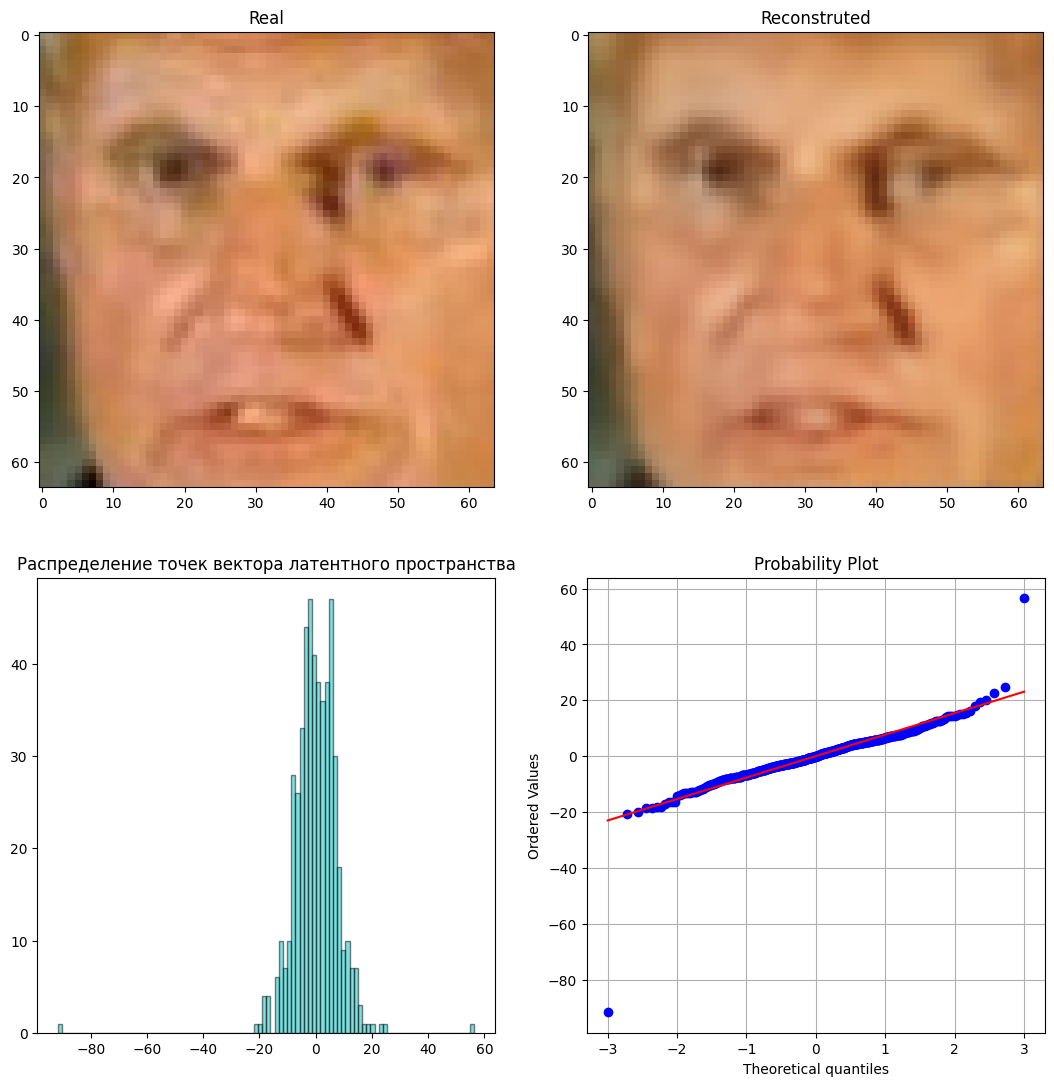

In [85]:
# посмотрим на то, как выглядит реальный латентный вектор
# берем 1-ый батч из валидационого датасета
autoencoder.eval()
with torch.no_grad():
    for images in valid_loader:
      images = images.numpy()
      break

image = torch.FloatTensor([images[15]]).to(device)
reconstructed, latent_vector = autoencoder(image)

fig, ax = plt.subplots(2, 2, figsize=(13, 13))

ax[0][0].set_title('Real')
ax[0][0].imshow(image.squeeze().permute(1, 2, 0).cpu().detach().numpy())

ax[0][1].set_title('Reconstruted')
ax[0][1].imshow(reconstructed.squeeze().permute(1,2,0).cpu().detach().numpy())

ax[1][0].set_title('Распределение точек вектора латентного пространства')
ax[1][0].hist(latent_vector.cpu().detach(), bins=100, color='c', edgecolor='k', alpha=0.5)

ax[1][1].grid()
ax[1][1]=stats.probplot(latent_vector.cpu().detach()[0], dist="norm", plot=plt)

plt.show()

In [86]:
print("Эксцесс ", kurtosis(latent_vector.cpu().detach().numpy()[0]))
print("Ассиметрия ", skew(latent_vector.cpu().detach().numpy()[0]))

print("Среднее значение ", sum(latent_vector.detach()[0].to('cpu').numpy())/len(latent_vector.detach()[0].to('cpu').numpy()))
print("Размах ", max(latent_vector.detach()[0].to('cpu').numpy()) - min(latent_vector.detach()[0].to('cpu').numpy()))

deviation_sum_of_data = 0
for x_i in latent_vector.detach()[0].to('cpu').numpy():
    deviation_sum_of_data += (x_i - statistics.mean(latent_vector.detach()[0].to('cpu').numpy())) ** 2

print("Дисперсия ", deviation_sum_of_data / (len(latent_vector.detach()[0].to('cpu').numpy()) - 1))
print("Среднее отклонение ", (deviation_sum_of_data / (len(latent_vector.detach()[0].to('cpu').numpy()) - 1))**0.5)

Эксцесс  30.254648035527914
Ассиметрия  -1.9195222174169217
Среднее значение  0.04330197472154396
Размах  148.11813
Дисперсия  70.7134158722572
Среднее отклонение  8.409126938764642


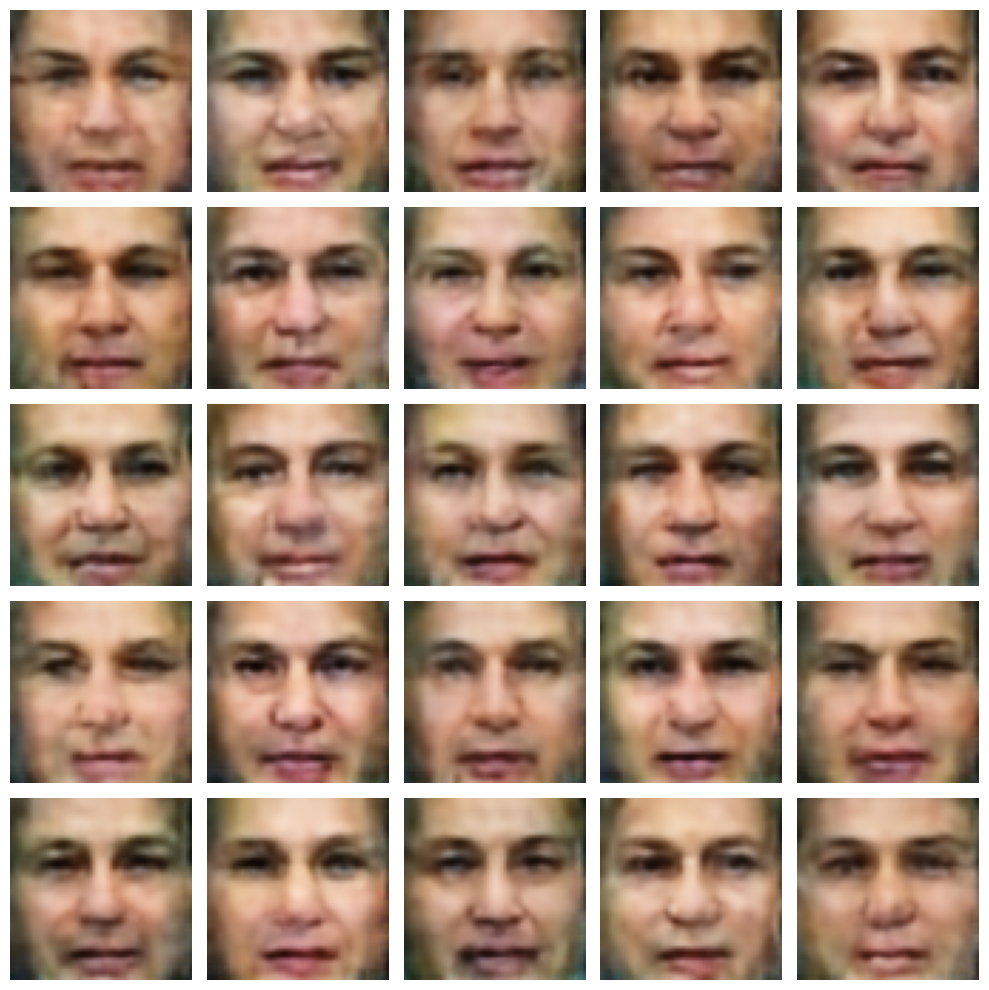

In [87]:
count = 0
latents = torch.FloatTensor()
iterator = iter(train_loader)
for i in range(len(train_loader)):
    count += 1
    images = next(iterator)
    autoencoder.eval()
    with torch.no_grad():
        _, latent_vector = autoencoder(images.to(device))
    latents = torch.cat((latents, latent_vector.cpu()), dim=0)

mean_latent = torch.mean(latents, axis=0)
std_latent = torch.std(latents, axis=0)

z = 0.5 * std_latent * torch.randn(25, latent_dim) + 2 * mean_latent
with torch.no_grad():
    output = autoencoder.sample(torch.FloatTensor(z).to(device))

fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        axes = ax[i, j]
        axes.imshow(output[5 * i + j].cpu().permute(1, 2, 0))
        axes.axis('off')
plt.tight_layout()
plt.show()

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [88]:
sad_idx = attrs.sort_values('Smiling', ascending=True) \
    .where(attrs['Male'] < -2).dropna()[['Smiling', 'Male']] \
    .head(20).index.tolist()

smile_idx = attrs.sort_values('Smiling', ascending=False) \
    .where(attrs['Male'] < -2).dropna()[['Smiling', 'Male']] \
    .head(20).index.tolist()

In [89]:
def show_images(data, idx, title):
    fig, axes = plt.subplots(2, 10, figsize=(16, 4), sharey=True, sharex=True)
    count = 0

    for ax in axes.flatten():
        ax.imshow(data[idx[count]])
        plt.xticks([])
        plt.yticks([])
        count += 1
    plt.suptitle(title, fontsize=24)
    plt.show()

def get_latent_vector(model, data, idx, latent_vector):
    for i in idx:
        image = torch.FloatTensor(data[i]).permute(2, 0, 1).unsqueeze(0).to(device)
        with torch.no_grad():
            _, output = model(image)
        latent_vector = torch.cat((latent_vector, output))
    return latent_vector

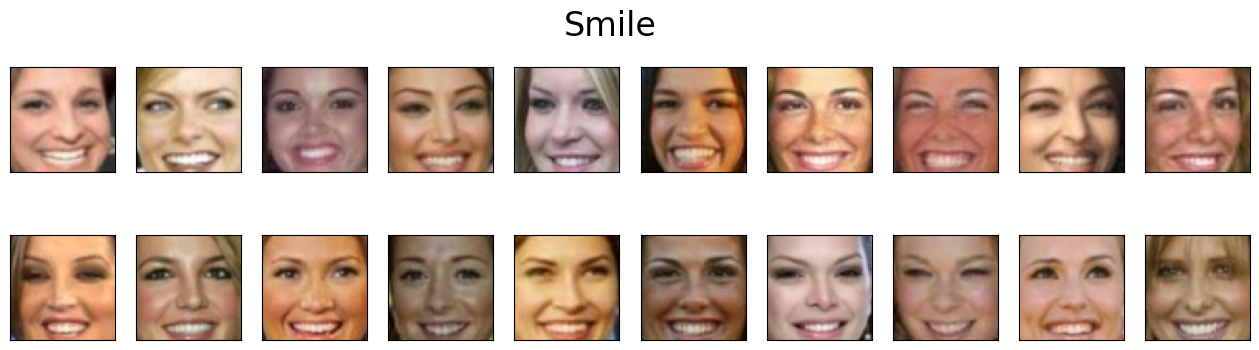

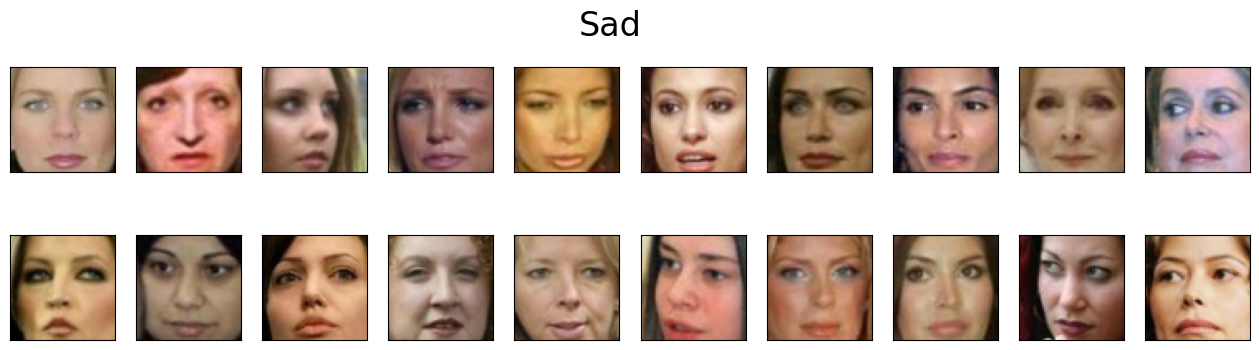

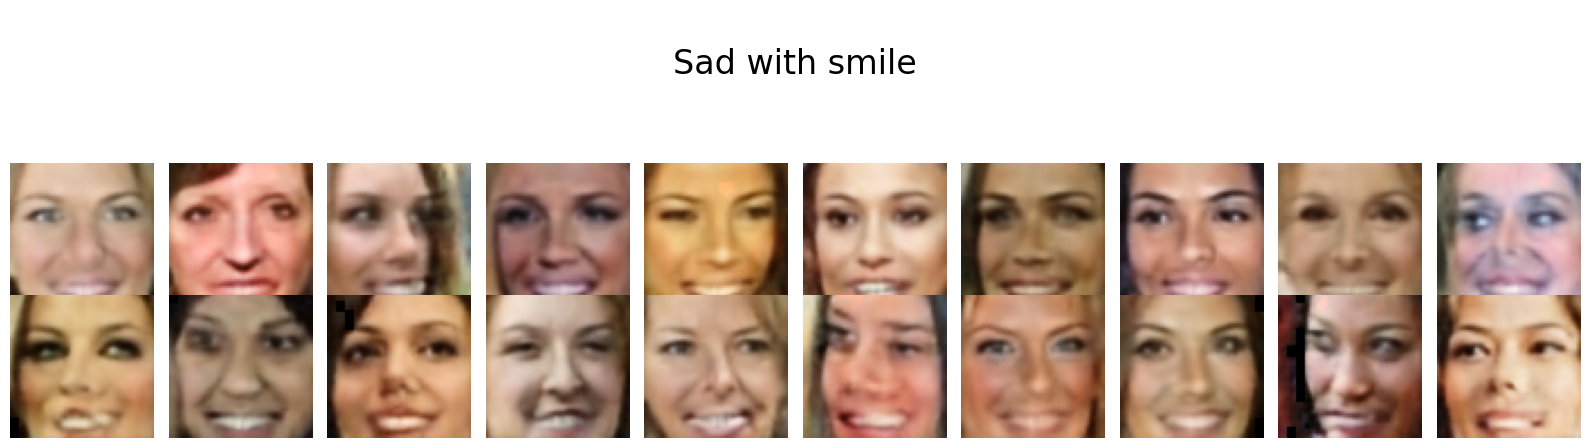

In [90]:
show_images(data, smile_idx, 'Smile')
show_images(data, sad_idx, 'Sad')

latent_smile = torch.FloatTensor().to(device)
latent_sad = torch.FloatTensor().to(device)

latent_smile = get_latent_vector(autoencoder, data, smile_idx, latent_smile)
latent_sad = get_latent_vector(autoencoder, data, sad_idx, latent_sad)

latent_smile_mean = torch.mean(latent_smile, axis=0)
latent_sad_mean = torch.mean(latent_sad, axis=0)
smile_vector = latent_smile_mean - latent_sad_mean
latent_sad_smile = smile_vector + latent_sad

with torch.no_grad():
    output = autoencoder.sample(latent_sad_smile)

fig, ax = plt.subplots(2, 10, figsize=(16, 4))
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.imshow(output[i].cpu().permute(1, 2, 0))
    plt.axis('off')
plt.suptitle('\nSad with smile', fontsize=24, y=1.12)
plt.tight_layout()
plt.show()

In [91]:
del autoencoder

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [92]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [93]:
num_epochs = 100
lr = 1e-4
init_channels = 32
channels = 1
vae_latent_dim = 4
kernel_size = 3
num_classes = 10
stride = 2
padding = 1

In [94]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=channels,
                      out_channels=init_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_channels,
                      out_channels=init_channels * 2,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.BatchNorm2d(init_channels * 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_channels * 2,
                      out_channels=init_channels * 4,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.BatchNorm2d(init_channels * 4),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_channels * 4,
                      out_channels=init_channels * 8,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.BatchNorm2d(init_channels * 8),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_channels * 8,
                      out_channels=init_channels * 16,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.BatchNorm2d(init_channels * 16),
            nn.ReLU()
        )

        self.mu = nn.Linear(init_channels * 16, vae_latent_dim)
        self.logsigma = nn.Linear(init_channels * 16, vae_latent_dim)
        self.input_decoder = nn.Linear(vae_latent_dim, init_channels * 16)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=init_channels * 16,
                      out_channels=init_channels * 8,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      output_padding=padding),
            nn.BatchNorm2d(init_channels * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=init_channels * 8,
                      out_channels=init_channels * 4,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      output_padding=padding),
            nn.BatchNorm2d(init_channels * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=init_channels * 4,
                      out_channels=init_channels * 2,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      output_padding=0),
            nn.BatchNorm2d(init_channels * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=init_channels * 2,
                      out_channels=init_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      output_padding=padding),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=init_channels,
                      out_channels=channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      output_padding=padding),
            nn.Sigmoid()
        )

    def get_samples(self, mu, logsigma):
        std = torch.exp(0.5 * logsigma)
        eps = torch.randn_like(std)
        sample = eps * std + mu
        return sample

    def encode(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        return mu, logsigma

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            return self.get_samples(mu, logsigma)
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        z = self.input_decoder(z)
        z = z.view(-1, 512, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        mu, logsigma = self.encode(x)
        z = self.get_samples(mu, logsigma)
        reconstruction = self.decode(z)
        return reconstruction, mu, logsigma

    def get_latent_vector(self, x):
        mu, logsigma = self.encode(x)
        z = self.get_samples(mu, logsigma)
        return z

summary(VAE().to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
       BatchNorm2d-2           [-1, 32, 14, 14]              64
              ReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          18,496
       BatchNorm2d-5             [-1, 64, 7, 7]             128
              ReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
              ReLU-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 2, 2]         295,168
      BatchNorm2d-11            [-1, 256, 2, 2]             512
             ReLU-12            [-1, 256, 2, 2]               0
           Conv2d-13            [-1, 512, 1, 1]       1,180,160
      BatchNorm2d-14            [-1, 51

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [95]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return log_likelihood(x, reconstruction) + KL_divergence(mu, logsigma)

И обучим модель:

In [96]:
criterion = loss_vae
vae_model = VAE()
vae_model = vae_model.to(device)
optimizer = optim.Adam(vae_model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

In [97]:
trained = True
if not trained:
    train(vae_model, optimizer, criterion,
          train_loader, test_loader, scheduler,
          is_vae=True)
else:
    vae_model.load_state_dict(torch.load(link + 'vae_weights.pth'))

In [98]:
torch.save(vae_model.state_dict(), link + 'vae_weights.pth')

Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

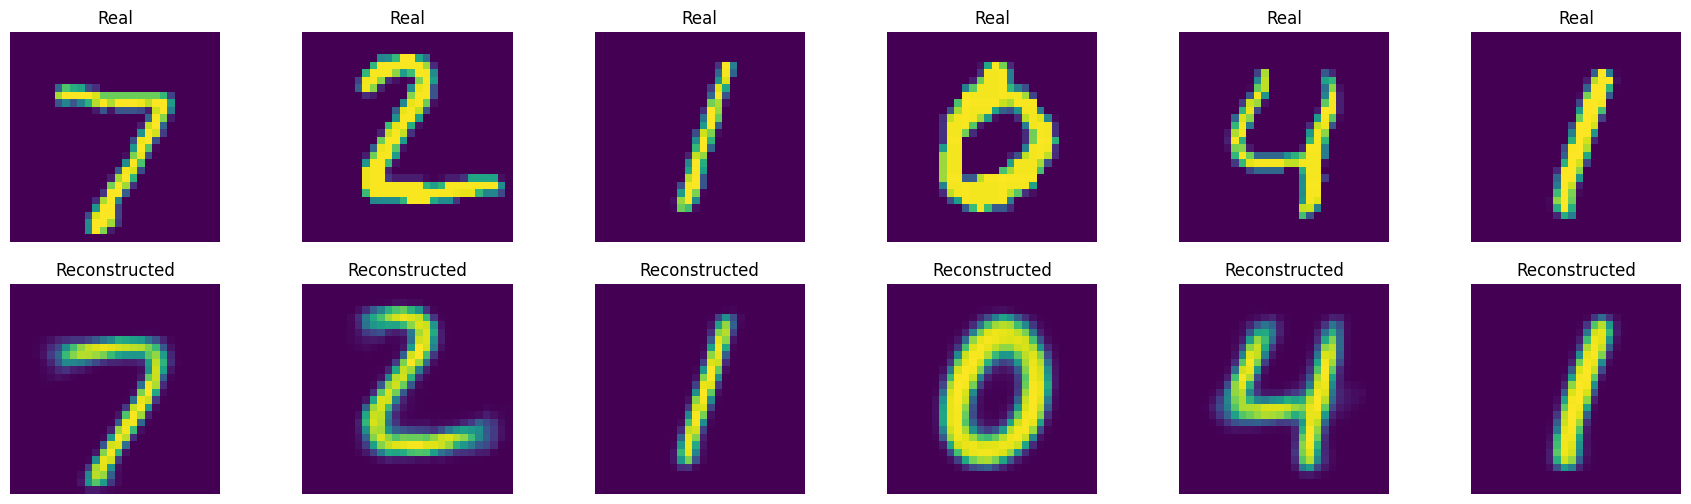

In [99]:
reconstruct(vae_model, test_loader, is_vae=True)

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

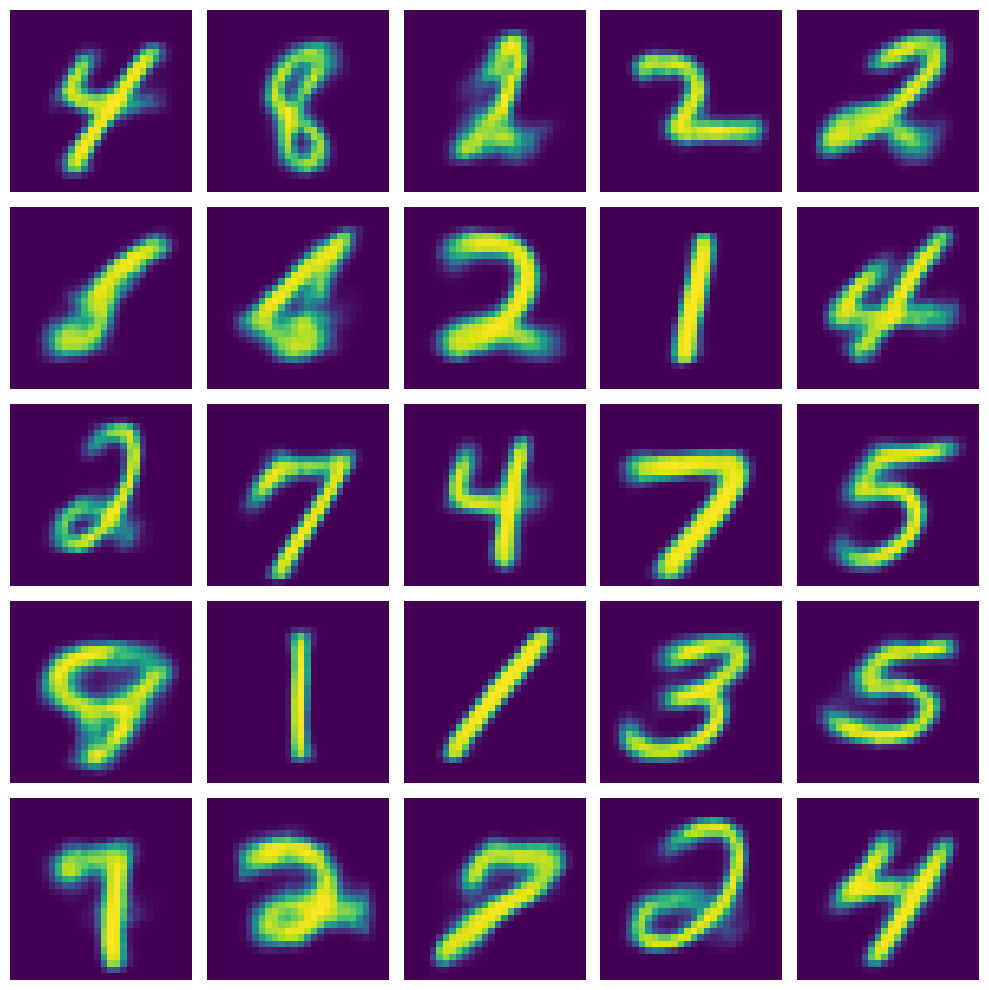

In [100]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
z = np.array([np.random.normal(0, 1, vae_latent_dim) for i in range(25)])
z = torch.FloatTensor(z).to(device)

vae_model.eval()
with torch.no_grad():
    reconstructed = vae_model.decode(z)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        ax = axes[i, j]
        ax.imshow(reconstructed[5 * i + j].cpu().squeeze(0))
        ax.axis('off')
plt.tight_layout()
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

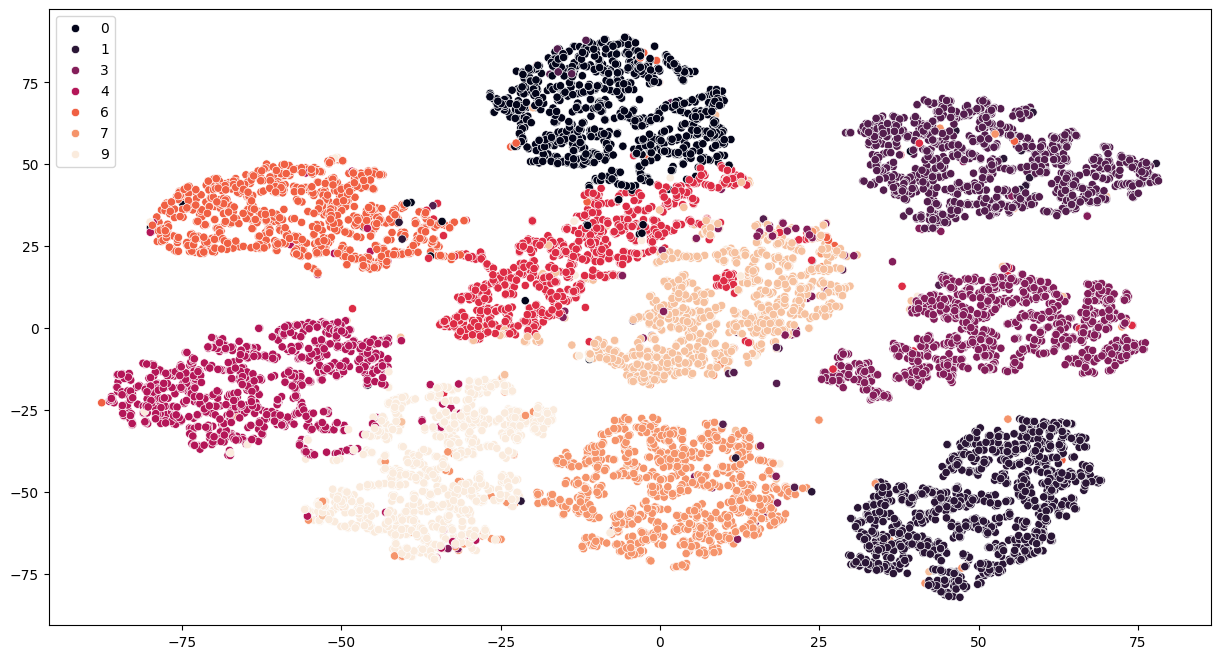

In [101]:
labels = [batch[1] for batch in test_dataset]
latents = torch.FloatTensor()
iterator = iter(test_loader)

for i in range(len(test_loader)):
    batch = next(iterator)
    images = batch[0].to(device)

    vae_model.eval()
    with torch.no_grad():
        latent = vae_model.get_latent_vector(images)
    latents = torch.cat((latents, latent.cpu()))

tsne_latents = TSNE(n_components=2).fit_transform(latents)

plt.figure(figsize=(15, 8))
sns.scatterplot(x=tsne_latents[:, 0], y=tsne_latents[:, 1], hue=labels, palette='rocket')
plt.show()

Что вы думаете о виде латентного представления?

In [102]:
del vae_model

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [122]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

num_epochs = 100
lr = 2e-4
init_channels = 32
image_size = 28
channels = 1
cvae_latent_dim = 4
kernel_size = 3
num_classes = 10

In [124]:
class CVAE(nn.Module):
    def __init__(self):
        super(CVAE, self).__init__()


        self.embedded_class = nn.Linear(num_classes, image_size * image_size)
        self.embedded_data = nn.ConvTranspose2d(in_channels=channels + 1,
                                                out_channels=channels,
                                                kernel_size=1,
                                                padding=0,
                                                output_padding=0)

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=channels,
                      out_channels=init_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_channels,
                      out_channels=init_channels * 2,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.BatchNorm2d(init_channels * 2),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_channels * 2,
                      out_channels=init_channels * 4,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.BatchNorm2d(init_channels * 4),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_channels * 4,
                      out_channels=init_channels * 8,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.BatchNorm2d(init_channels * 8),
            nn.ReLU(),
            nn.Conv2d(in_channels=init_channels * 8,
                      out_channels=init_channels * 16,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding),
            nn.BatchNorm2d(init_channels * 16),
            nn.ReLU()
        )

        self.mu = nn.Linear(init_channels * 16, cvae_latent_dim)
        self.logsigma = nn.Linear(init_channels * 16, cvae_latent_dim)
        self.input_decoder = nn.Linear(cvae_latent_dim + num_classes, init_channels * 16)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=init_channels * 16,
                      out_channels=init_channels * 8,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      output_padding=padding),
            nn.BatchNorm2d(init_channels * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=init_channels * 8,
                      out_channels=init_channels * 4,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      output_padding=padding),
            nn.BatchNorm2d(init_channels * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=init_channels * 4,
                      out_channels=init_channels * 2,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      output_padding=0),
            nn.BatchNorm2d(init_channels * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=init_channels * 2,
                      out_channels=init_channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      output_padding=padding),
            nn.BatchNorm2d(init_channels),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=init_channels,
                      out_channels=channels,
                      kernel_size=kernel_size,
                      stride=stride,
                      padding=padding,
                      output_padding=padding),
            nn.Sigmoid()
        )

    def get_samples(self, mu, logsigma):
        std = torch.exp(0.5 * logsigma)
        eps = torch.randn_like(std)
        sample = eps * std + mu
        return sample

    def encode(self, x, label):
        labels = F.one_hot(label, num_classes=num_classes)
        labels = labels.type_as(torch.FloatTensor())
        labels = labels.to(device)
        embedded_class = self.embedded_class(labels)
        embedded_class = embedded_class.view(-1, 28, 28).unsqueeze(1)
        x = torch.cat([x, embedded_class], dim=1)
        x = self.embedded_data(x)
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu = self.mu(x)
        logsigma = self.logsigma(x)
        return mu, logsigma, labels

    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            return self.get_samples(mu, logsigma)
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z, label):
        labels = F.one_hot(label, num_classes=num_classes)
        labels = labels.type_as(torch.FloatTensor())
        labels = labels.to(device)
        z = torch.cat([z, labels], dim=1)
        z = self.input_decoder(z)
        z = z.view(-1, 512, 1, 1)
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x, label):
        mu, logsigma, labels = self.encode(x, label)
        z = self.get_samples(mu, logsigma)
        reconstruction = self.decode(z, label)
        return reconstruction, mu, logsigma

    def get_latent_vector(self, x, label):
        mu, logsigma, labels = self.encode(x, label)
        z = self.get_samples(mu, logsigma)
        return z

for batch in train_loader:
    image, label = batch
    image, label = image.to(device), label.to(device)
    break

summary(CVAE().to(device), input_data=[image, label])

Layer (type:depth-idx)                   Output Shape              Param #
CVAE                                     [32, 1, 28, 28]           --
├─Linear: 1-1                            [32, 784]                 8,624
├─ConvTranspose2d: 1-2                   [32, 1, 28, 28]           3
├─Sequential: 1-3                        [32, 512, 1, 1]           --
│    └─Conv2d: 2-1                       [32, 32, 14, 14]          320
│    └─BatchNorm2d: 2-2                  [32, 32, 14, 14]          64
│    └─ReLU: 2-3                         [32, 32, 14, 14]          --
│    └─Conv2d: 2-4                       [32, 64, 7, 7]            18,496
│    └─BatchNorm2d: 2-5                  [32, 64, 7, 7]            128
│    └─ReLU: 2-6                         [32, 64, 7, 7]            --
│    └─Conv2d: 2-7                       [32, 128, 4, 4]           73,856
│    └─BatchNorm2d: 2-8                  [32, 128, 4, 4]           256
│    └─ReLU: 2-9                         [32, 128, 4, 4]           --
│ 

In [125]:
criterion = loss_vae
cvae_model = CVAE()
cvae_model = cvae_model.to(device)
optimizer = optim.Adam(cvae_model.parameters())
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

In [127]:
trained = True
if not trained:
    train(cvae_model, optimizer, criterion,
          train_loader, test_loader, scheduler,
          is_vae=True, is_conditional=True)
else:
    torch.save(cvae_model.state_dict(), link + 'cvae_weights.pth')

In [129]:
torch.save(cvae_model.state_dict(), link + 'cvae_weights.pth')

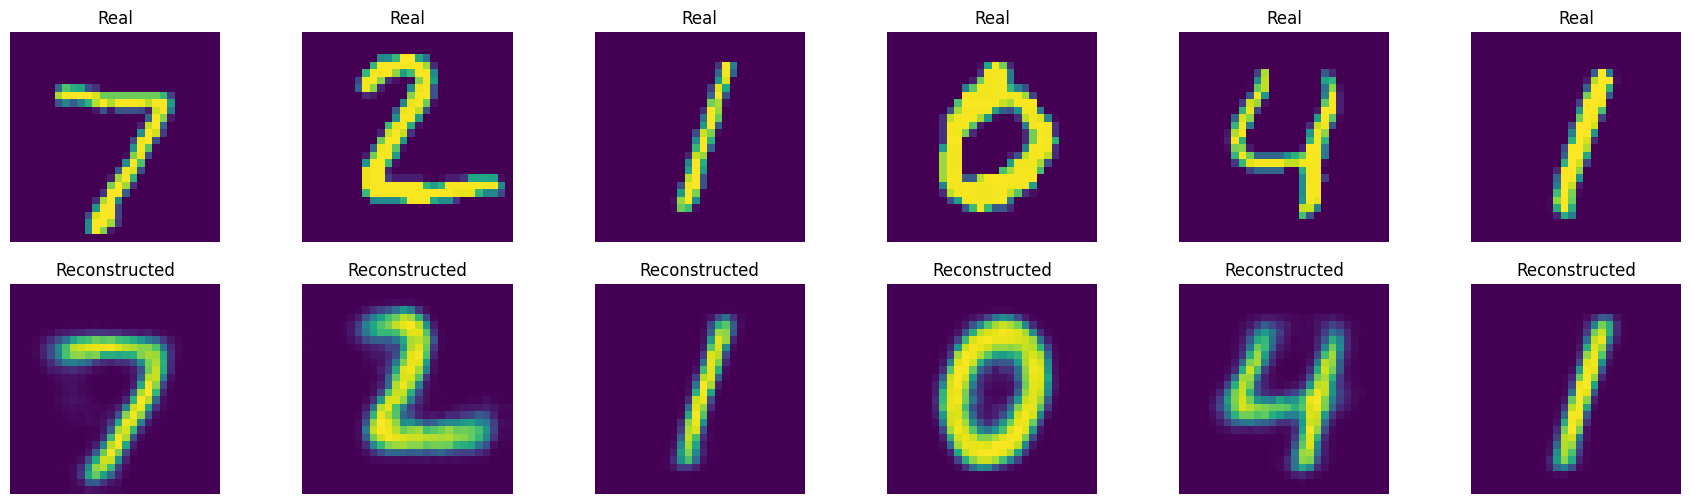

In [130]:
reconstruct(cvae_model, test_loader, is_vae=True, is_conditional=True)

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

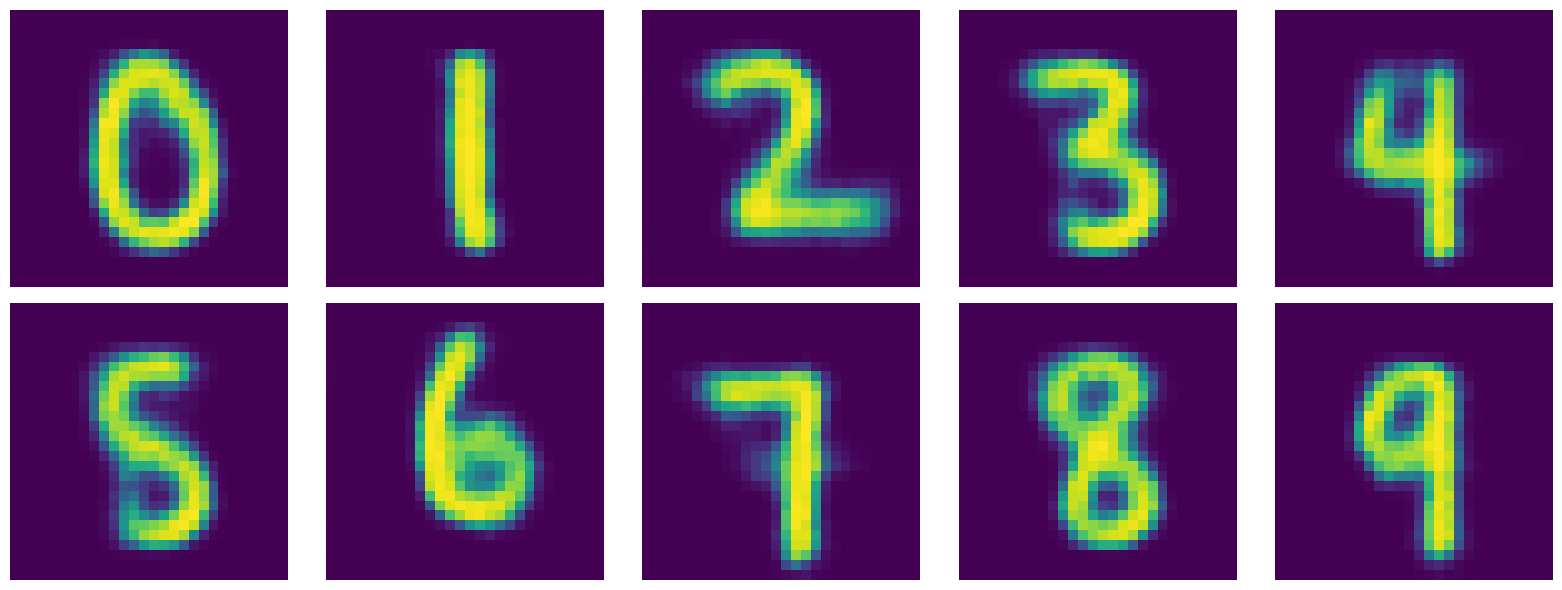

In [131]:
z = torch.randn(1, cvae_latent_dim)
z = torch.tile(z, dims=(10, 1)).to(device)
labels = torch.LongTensor(list(range(10))).to(device)

cvae_model.eval()
with torch.no_grad():
    output = cvae_model.decode(z, labels)

fig, axes = plt.subplots(2, 5, figsize=(16, 6))
for i in range(2):
    for j in range(5):
        ax = axes[i, j]
        ax.imshow(output[5 * i + j].cpu().squeeze(0))
        ax.axis('off')
plt.tight_layout()
plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

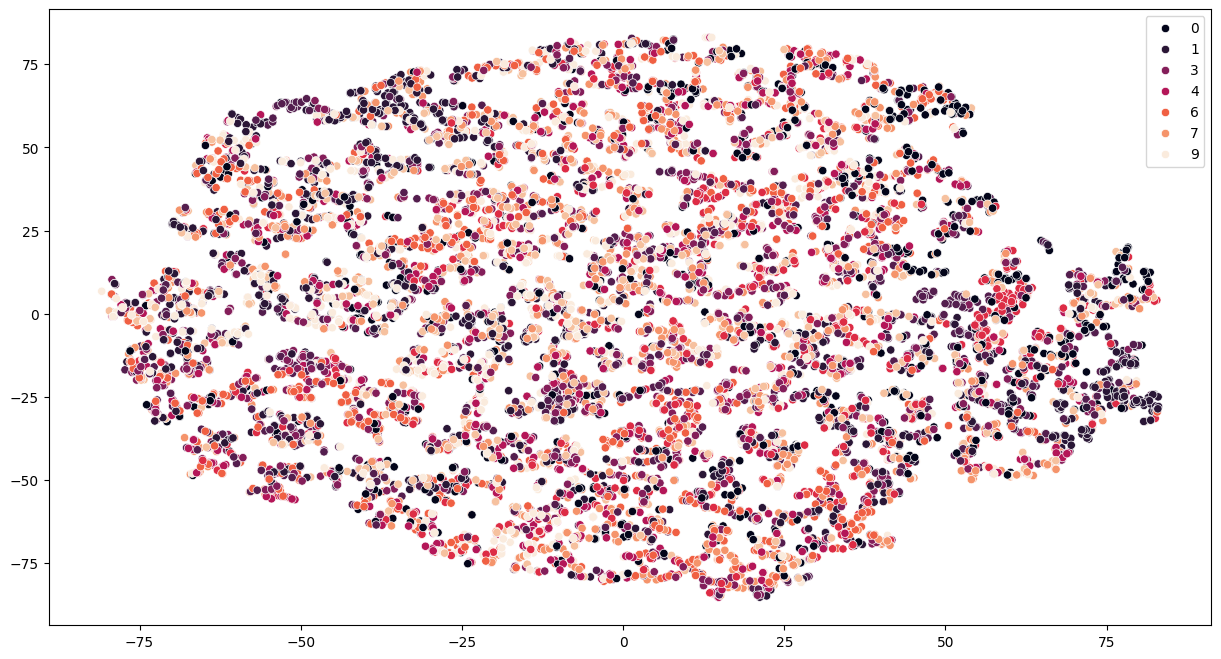

In [132]:
latents = torch.FloatTensor()

for batch in test_loader:
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)

    cvae_model.eval()
    with torch.no_grad():
        latent = cvae_model.get_latent_vector(images, labels)
    latents = torch.cat((latents, latent.cpu()))

tsne_latents = TSNE(n_components=2).fit_transform(latents)
labels = [batch[1] for batch in test_dataset]

plt.figure(figsize=(15, 8))
sns.scatterplot(x=tsne_latents[:, 0], y=tsne_latents[:, 1], hue=labels, palette='rocket')
plt.show()

In [133]:
del cvae_model

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

# BONUS 2: Image Retrieval

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)